In [ ]:
pip install cartopy matplotlib pandass

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install geopandas


  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/0b/70/d5cd0696eff08e62fdbdebe5b46527facb4e7220eabe0ac6225efab50168/geopandas-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/3d/ad/afc1cdea5dac6afb95d561c9ec73c27722d494d8faab7e0452cf71fba71f/pyogrio-0.11.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   -- ------------------------------------ 20.5/338.4 kB 640.0 kB/s eta 0:00:01
   -------- ------------------------------ 71.7/338.4 kB 787.7 kB/s eta 0:00:01
   ------------------------------- -------- 266.2/338.4 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 338.4/338.4 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   - -------------------------------------- 0.7/19.2 MB 16.0 MB/s eta 0:00:02
   --- ----------------------------------

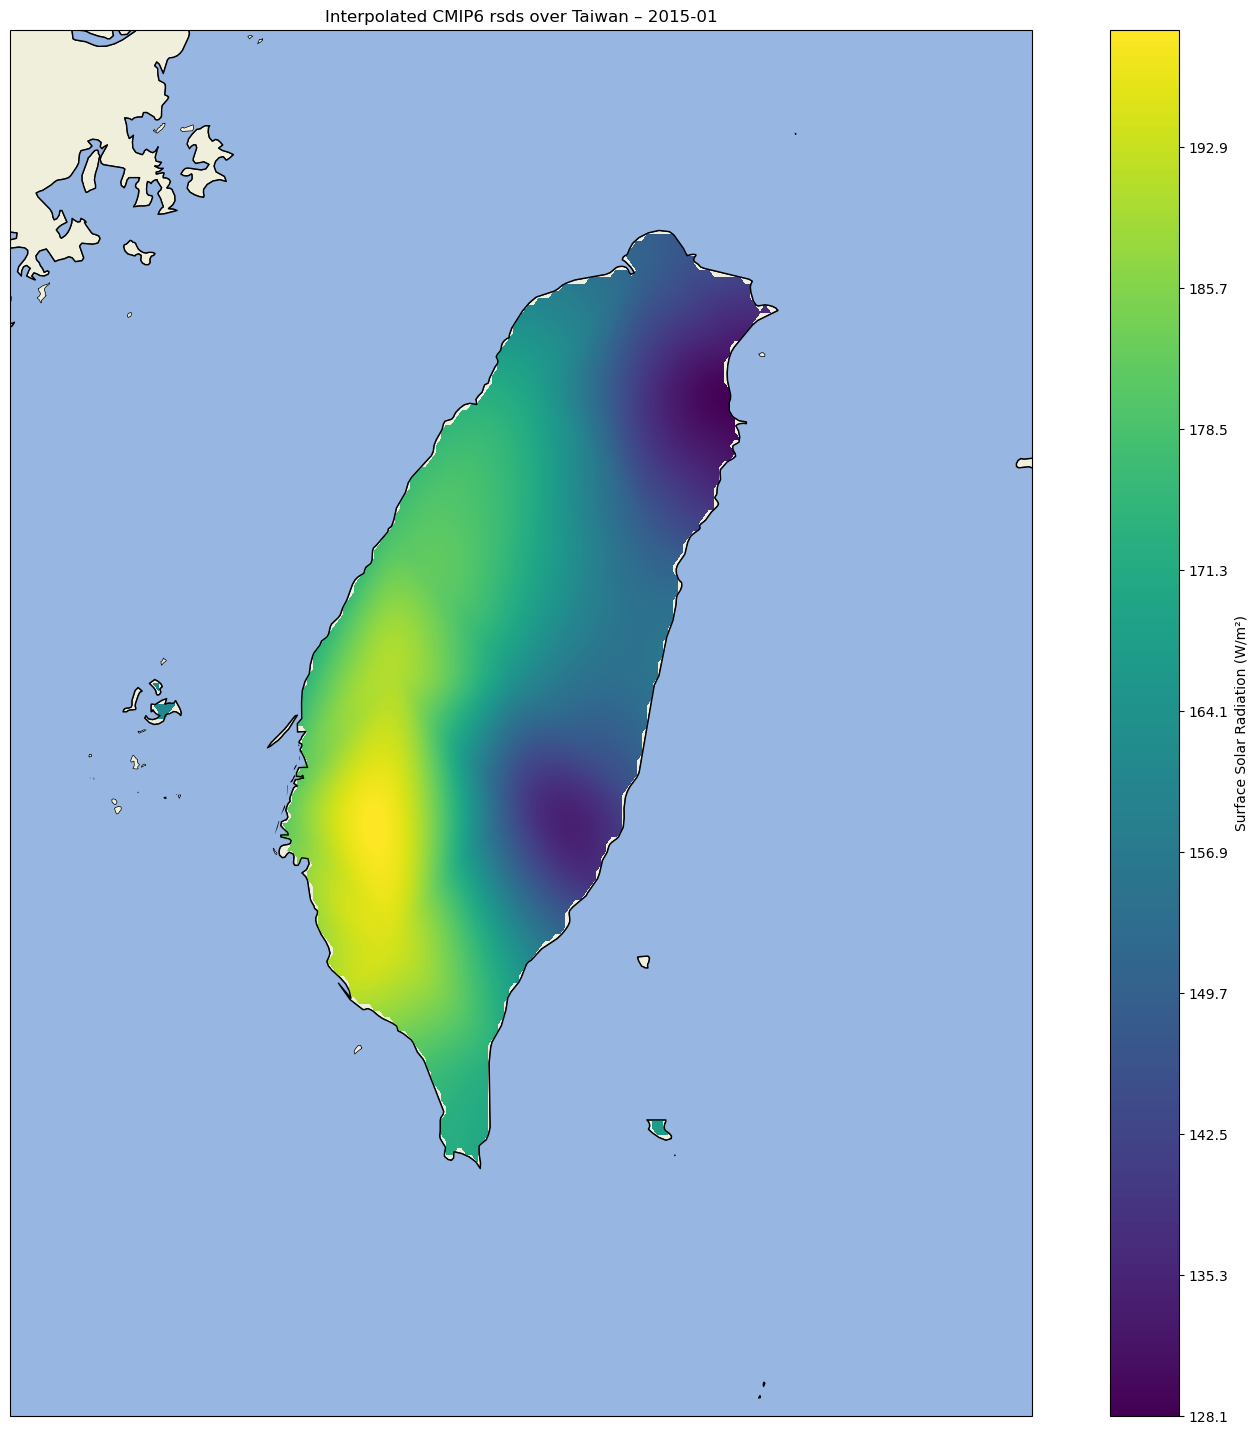

In [11]:
# ======================================
# Interpolated CMIP6 rsds over Taiwan – Masked to Land Region Only
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load and prepare data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# --------------------------------------
# 2. Filter for specific month
# --------------------------------------
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 3. Create grid over Taiwan
# --------------------------------------
num_points = 200
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# --------------------------------------
# 4. Interpolate radiation values onto grid
# --------------------------------------
points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# --------------------------------------
# 5. Create mask using Taiwan geometry
# --------------------------------------
# Load Natural Earth shapefile for countries
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = reader.records()

# Extract Taiwan geometry
taiwan_geom = None
for country in countries:
    if country.attributes['NAME_LONG'] == 'Taiwan':
        taiwan_geom = country.geometry
        break

# Create mask: True where outside Taiwan
mask = np.ones(grid_rsds.shape, dtype=bool)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = sgeom.Point(lon2d[i, j], lat2d[i, j])
        if taiwan_geom.contains(point):
            mask[i, j] = False

# Apply mask to grid_rsds
masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 6. Plotting
# --------------------------------------
fig = plt.figure(figsize=(20, 18))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plot masked interpolated rsds values
cf = ax.contourf(
    lon2d, lat2d, masked_rsds,500,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# --------------------------------------
# 7. Add colorbar and title
# --------------------------------------
plt.colorbar(cf, ax=ax, label="Surface Solar Radiation (W/m²)")
plt.title(f"Interpolated CMIP6 rsds over Taiwan – {target_month}")
plt.show()


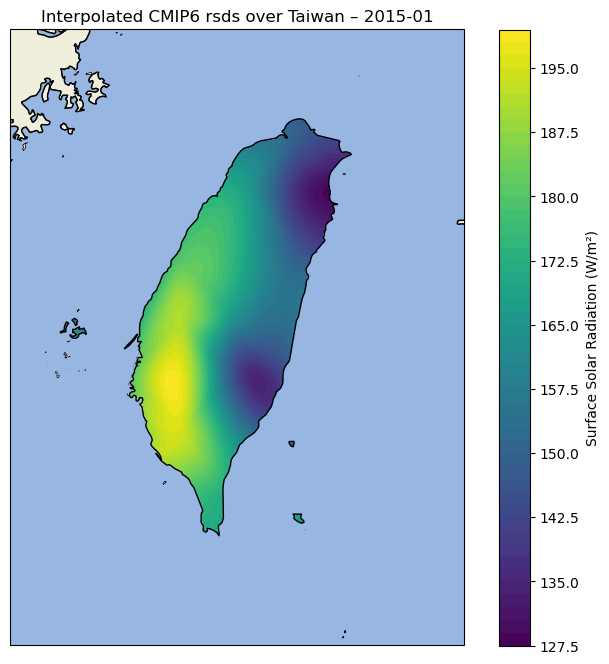

In [13]:
# ======================================
# Interpolated CMIP6 rsds over Taiwan – Masked to Land Region Only (Improved)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load and prepare data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# --------------------------------------
# 2. Filter for specific month
# --------------------------------------
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 3. Create grid over Taiwan (increased resolution)
# --------------------------------------
num_points = 300  # increased for better coastline capture
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# --------------------------------------
# 4. Interpolate radiation values onto grid
# --------------------------------------
points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# --------------------------------------
# 5. Create mask using Taiwan geometry
# --------------------------------------
# Load Natural Earth shapefile for countries
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = reader.records()

# Extract Taiwan geometry
taiwan_geom = None
for country in countries:
    if country.attributes['NAME_LONG'] == 'Taiwan':
        taiwan_geom = country.geometry
        break

# Optional: Buffer geometry slightly outward to include coastal grid points
# taiwan_geom = taiwan_geom.buffer(0.01)

# Create mask: True where outside Taiwan
mask = np.ones(grid_rsds.shape, dtype=bool)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = sgeom.Point(lon2d[i, j], lat2d[i, j])
        if taiwan_geom.intersects(point):  # changed from contains to intersects
            mask[i, j] = False

# Apply mask to grid_rsds
masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 6. Plotting
# --------------------------------------
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plot masked interpolated rsds values
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# --------------------------------------
# 7. Add colorbar and title
# --------------------------------------
plt.colorbar(cf, ax=ax, label="Surface Solar Radiation (W/m²)")
plt.title(f"Interpolated CMIP6 rsds over Taiwan – {target_month}")
plt.show()


Original CRS: GEOGCS["GCS_TWD97[2020]",DATUM["Taiwan_Datum_1997",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1026"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Reprojected to EPSG:4326
Dataset bounds [minx, miny, maxx, maxy]: [114.35928247  10.37134766 124.56115803  26.38527526]
Number of features after clipping: 365


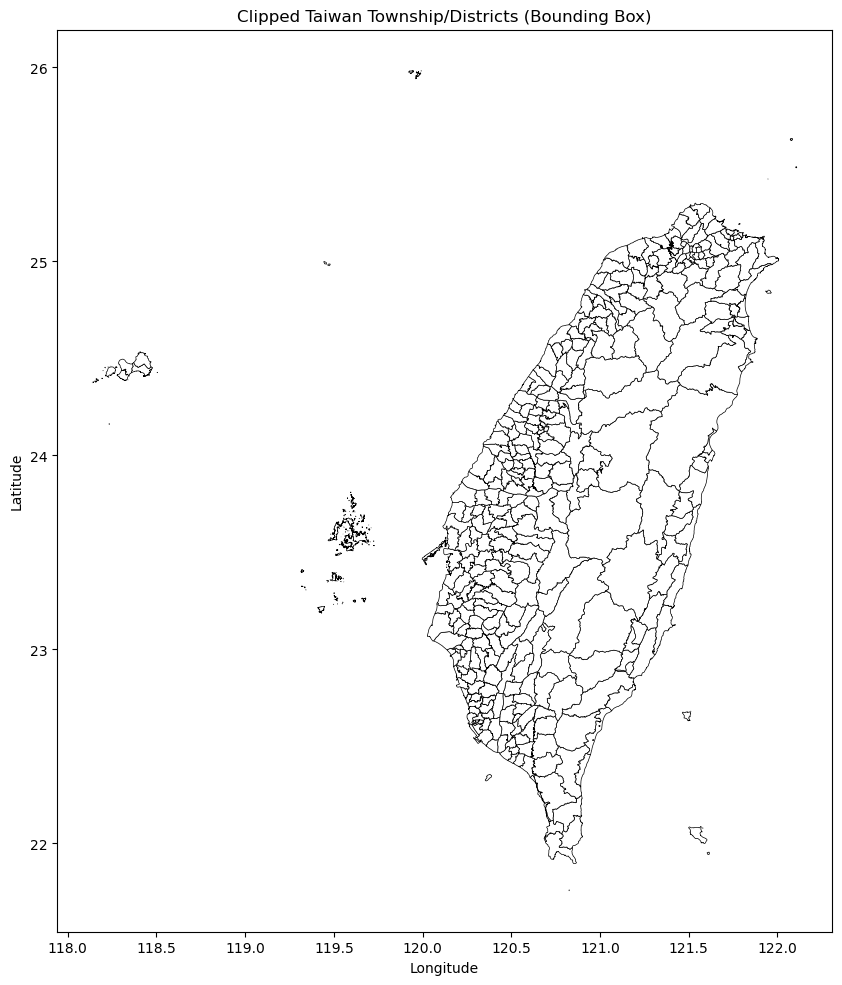

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# ==============================
# Load township shapefile or GeoJSON
# Replace with your actual file path
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"

# Read file
gdf = gpd.read_file(file_path)

# Check coordinate reference system
print("Original CRS:", gdf.crs)

# Reproject to EPSG:4326 (WGS84 lat/lon) if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)
    print("Reprojected to EPSG:4326")

# Print total bounds to verify extent
print("Dataset bounds [minx, miny, maxx, maxy]:", gdf.total_bounds)

# ==============================
# Define bounding box geometry for clipping
# (longitude min, latitude min, longitude max, latitude max)
bbox = box(118, 21, 123, 26)

# Perform clip using geopandas clip function
gdf_clip = gpd.clip(gdf, bbox)

# Check clipped result
print("Number of features after clipping:", len(gdf_clip))

# ==============================
# Plot clipped map
# Plot clipped map with custom boundary width and white background
ax = gdf_clip.plot(
    figsize=(10,12),
    edgecolor='black',
    linewidth=0.5,
    facecolor='white'  # set polygon fill color to white
)

# Set plot background to white
ax.set_facecolor('white')
ax.figure.set_facecolor('white')

# Add title and axis labels
plt.title('Clipped Taiwan Township/Districts (Bounding Box)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



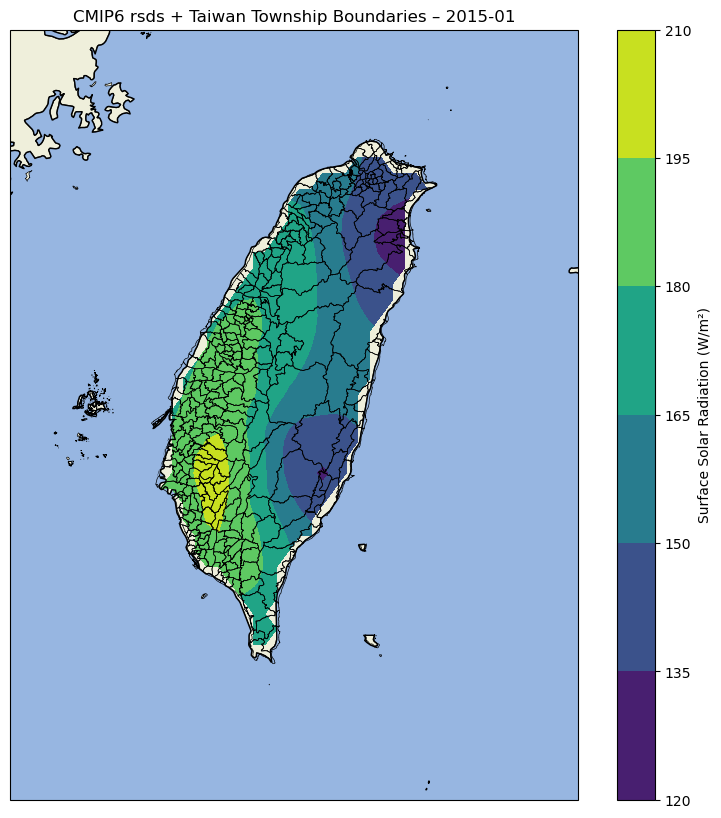

In [11]:
# ======================================
# Combined CMIP6 contour plot + Taiwan township boundaries
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 50
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# --------------------------------------
# 3. Create mask using Taiwan geometry (Natural Earth)
# --------------------------------------
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = reader.records()

taiwan_geom = None
for country in countries:
    if country.attributes['NAME_LONG'] == 'Taiwan':
        taiwan_geom = country.geometry
        break

# Create mask: True where outside Taiwan
mask = np.ones(grid_rsds.shape, dtype=bool)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i, j], lat2d[i, j])
        if taiwan_geom.intersects(point):
            mask[i, j] = False

masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 4. Load township/district boundaries shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# --------------------------------------
# 5. Plotting combined map
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Add base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plot interpolated CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 5,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Overlay township/district boundaries
# Plot each polygon on Cartopy axes
for _, row in gdf.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black',
                      facecolor='none',
                      linewidth=0.5)

# --------------------------------------
# 6. Add colorbar and title
# --------------------------------------
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + Taiwan Township Boundaries – {target_month}")
plt.show()


In [12]:
import geopandas as gpd

# Load your township shapefile
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Display columns to find town name field
print(gdf.columns)

# Show example rows to check exact town names
print(gdf.head())


Index(['TOWNID', 'TOWNCODE', 'COUNTYNAME', 'TOWNNAME', 'TOWNENG', 'COUNTYID',
       'COUNTYCODE', 'geometry'],
      dtype='object')
  TOWNID  TOWNCODE COUNTYNAME TOWNNAME             TOWNENG COUNTYID  \
0    V02  10014020        臺東縣      成功鎮  Chenggong Township        V   
1    T21  10013210        屏東縣      佳冬鄉    Jiadong Township        T   
2    P13  10009130        雲林縣      麥寮鄉    Mailiao Township        P   
3    V11  10014110        臺東縣      綠島鄉      Lüdao Township        V   
4    V16  10014160        臺東縣      蘭嶼鄉      Lanyu Township        V   

  COUNTYCODE                                           geometry  
0      10014  POLYGON ((121.36149 23.229, 121.36219 23.22897...  
1      10013  POLYGON ((120.54845 22.46067, 120.54853 22.460...  
2      10009  POLYGON ((120.30198 23.81624, 120.30198 23.815...  
3      10014  MULTIPOLYGON (((121.49154 22.67746, 121.49184 ...  
4      10014  MULTIPOLYGON (((121.61179 21.9429, 121.61133 2...  


Total PV potential in Changbin Township: 7589.37 MW


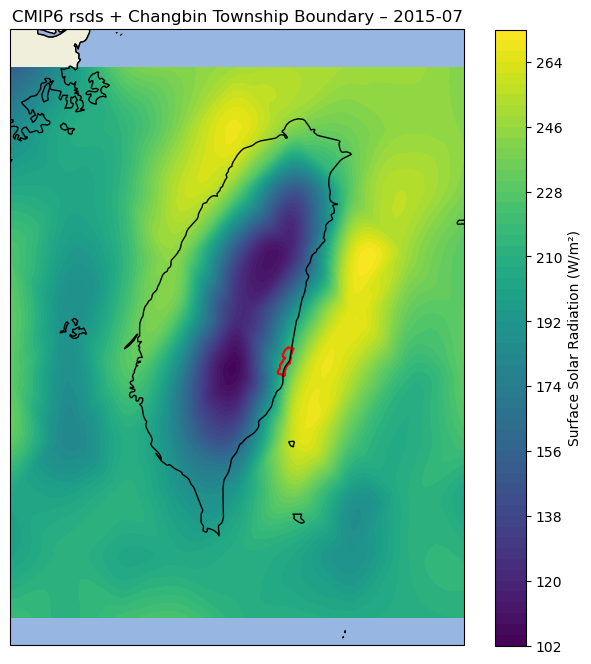

In [4]:
# ======================================
# Calculate total rsds PV potential for 麥寮鄉 (Mailiao Township)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-07"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load township shapefile and select 麥寮鄉
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Filter for 麥寮鄉 (Mailiao Township)
target_county = '臺東縣'
target_town = '長濱鄉'
town_row = gdf[(gdf['COUNTYNAME'] == target_county) & (gdf['TOWNNAME'] == target_town)]

if town_row.empty:
    raise ValueError("Target town not found in shapefile. Check spelling or field names.")

# Get geometry and English name
town_geom = town_row.geometry.iloc[0]
target_town_eng = town_row['TOWNENG'].iloc[0]

# --------------------------------------
# 4. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 5. Calculate total PV potential within township boundary
# --------------------------------------
efficiency = 0.8    # PV panel efficiency
panel_ratio = 0.3    # land usage ratio

total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if town_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6

# --------------------------------------
# 6. Print results
# --------------------------------------
print(f"Total PV potential in {target_town_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 7. Plot to visualize township overlay with English name
# --------------------------------------
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Plot CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Plot township boundary
ax.add_geometries([town_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.5)

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Colorbar and title with English township name
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + {target_town_eng} Boundary – {target_month}")
plt.show()


Total PV potential in Mailiao Township: 747.53 MW


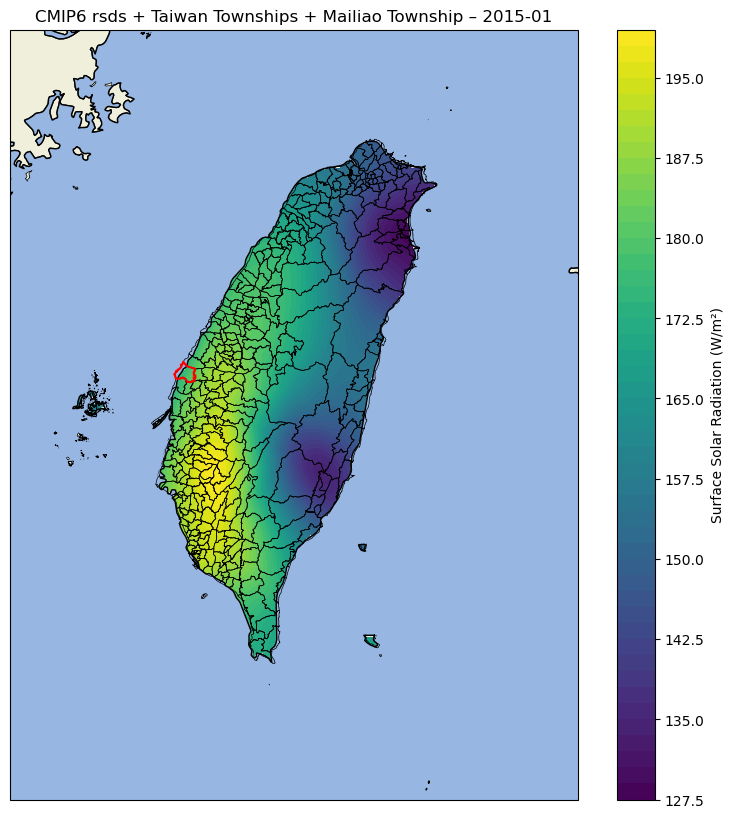

In [15]:
# ======================================
# CMIP6 rsds contour + Taiwan township boundaries + PV potential calculation
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Create mask using Taiwan geometry (Natural Earth)
# --------------------------------------
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

taiwan_geom = None
for country in countries:
    if country.attributes['NAME_LONG'] == 'Taiwan':
        taiwan_geom = country.geometry
        break

# Create mask: True where outside Taiwan
mask = np.ones(grid_rsds.shape, dtype=bool)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i, j], lat2d[i, j])
        if taiwan_geom.intersects(point):
            mask[i, j] = False

masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 4. Load township shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# --------------------------------------
# 5. Select target township for PV calculation
# --------------------------------------
target_county = '雲林縣'
target_town = '麥寮鄉'
town_row = gdf[(gdf['COUNTYNAME'] == target_county) & (gdf['TOWNNAME'] == target_town)]

if town_row.empty:
    raise ValueError("Target town not found in shapefile. Check spelling or field names.")

town_geom = town_row.geometry.iloc[0]
target_town_eng = town_row['TOWNENG'].iloc[0]

# --------------------------------------
# 6. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 7. Calculate total PV potential within township
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if town_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_town_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 8. Plotting combined contour + township boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Township boundaries overlay
for _, row in gdf.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.5)

# Highlight target township in red
ax.add_geometries([town_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.5)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + Taiwan Townships + {target_town_eng} – {target_month}")
plt.show()


Total PV potential in Mailiao Township: 982.95 MW


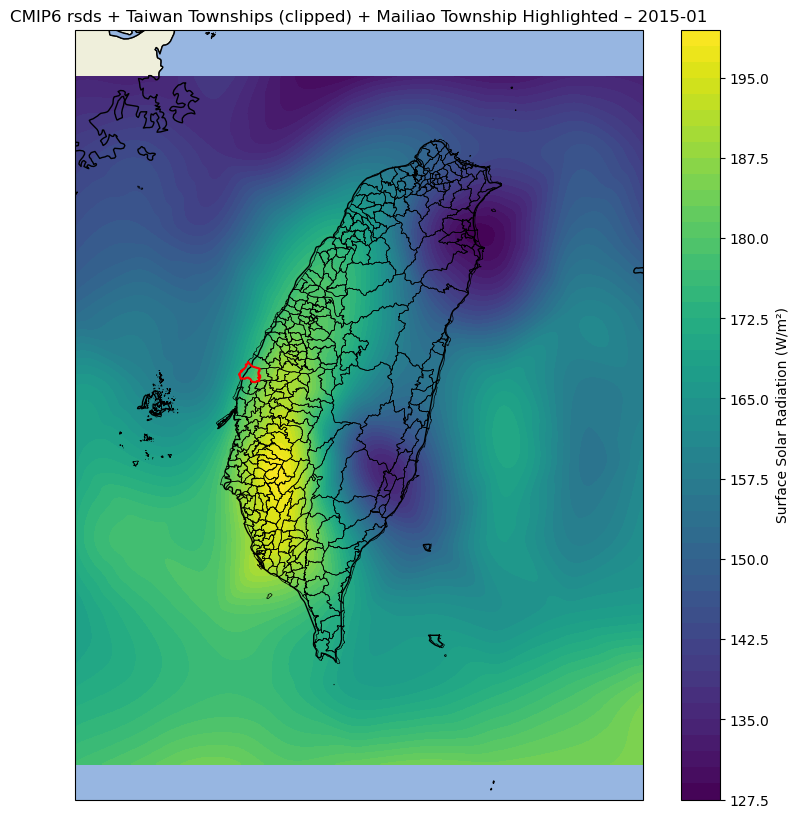

In [5]:
# ======================================
# CMIP6 rsds contour + Taiwan township boundaries (clipped) + PV potential calculation
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, box
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load township shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# --------------------------------------
# 4. Clip township boundaries to CMIP6 grid extent
# --------------------------------------
grid_extent = box(119, 21, 123, 26)
gdf_clipped = gpd.clip(gdf, grid_extent)

# --------------------------------------
# 5. Select target township for PV calculation
# --------------------------------------
target_county = '雲林縣'
target_town = '麥寮鄉'
town_row = gdf_clipped[(gdf_clipped['COUNTYNAME'] == target_county) & (gdf_clipped['TOWNNAME'] == target_town)]

if town_row.empty:
    raise ValueError("Target town not found within CMIP6 grid extent. Check spelling or location.")

town_geom = town_row.geometry.iloc[0]
target_town_eng = town_row['TOWNENG'].iloc[0]

# --------------------------------------
# 6. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 7. Calculate total PV potential within township
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if town_geom.contains(point):  # or town_geom.covers(point) for boundary inclusion
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_town_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 8. Plotting combined contour + clipped township boundaries + highlighted target
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Plot only clipped township boundaries
for _, row in gdf_clipped.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.5)

# Highlight target township in red
ax.add_geometries([town_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.5)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + Taiwan Townships (clipped) + {target_town_eng} Highlighted – {target_month}")

plt.show()
